In [1]:
#conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

In [2]:
#!pip3 install torchsummary

In [17]:
import PIL
import cv2
import itertools
import numpy as np
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

import time

import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [4]:
torch.cuda.is_available()

False

In [5]:
torch.__version__

'2.1.0'

In [6]:
# random.seed(42)
# source_dir = '/home/hduser/Desktop/augmented data pytorch/'  # Replace with your actual source directory
# os.chdir(source_dir)

# # Create directories
# for category in ['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 
#                  'hortorum', 'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 
#                  'monticola', 'muscorum', 'pascuorum', 'pratorum', 'ruderarius', 
#                  'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']:
#     os.makedirs(f'train/bombus {category}')
#     os.makedirs(f'validate/bombus {category}')

# # Move files to train directory
# for category in ['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 
#                  'hortorum', 'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 
#                  'monticola', 'muscorum', 'pascuorum', 'pratorum', 'ruderarius', 
#                  'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']:
#     files = glob.glob(os.path.join(source_dir, f'{category}/*'))
#     for i in random.sample(files, min(256, len(files))):
#         shutil.move(i, f'train/bombus {category}')

# # Move files to validate directory
# for category in ['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 'hortorum',
#                  'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 'monticola', 'muscorum',
#                  'pascuorum', 'pratorum', 'ruderarius', 'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']:
#     files = glob.glob(os.path.join(source_dir, f'{category}/*'))
#     for i in random.sample(files, min(64, len(files))):
#         shutil.move(i, f'validate/bombus {category}')

In [7]:
from torchvision import transforms

squeezenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

# # Applying Transforms to the Data
# squeezenet_transform = { 
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=15),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ]),
#     'validate': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])
#}

In [8]:
# Load the Data
# Set train and valid directory paths
train_path = 'train'
validate_path = 'validate'

# Batch size
bs = 64

# Number of classes
num_classes = len(os.listdir(validate_path))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_path, transform=squeezenet_transform),
    'valid': datasets.ImageFolder(root=validate_path, transform=squeezenet_transform)
}


# data = {
#     'train': datasets.ImageFolder(root=train_path, transform=squeezenet_transform['train']),
#     'valid': datasets.ImageFolder(root=validate_path, transform=squeezenet_transform['valid'])
# }

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
validate_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
validate_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

21
{0: 'bombus barbutellus', 1: 'bombus bohemicus', 2: 'bombus campestris', 3: 'bombus cryptarum', 4: 'bombus distinguendus', 5: 'bombus hortorum', 6: 'bombus hypnorum', 7: 'bombus jonellus', 8: 'bombus lapidarius', 9: 'bombus lucorum', 10: 'bombus magnus', 11: 'bombus monticola', 12: 'bombus muscorum', 13: 'bombus pascuorum', 14: 'bombus pratorum', 15: 'bombus ruderarius', 16: 'bombus rupestris', 17: 'bombus sylvarum', 18: 'bombus sylvestris', 19: 'bombus terrestris', 20: 'bombus vestalis'}


In [9]:
train_data_size, validate_data_size

(5376, 1344)

In [10]:
model_squeezenet = models.squeezenet1_1(weights='DEFAULT')
model_squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [11]:
# Freeze model parameters
for param in model_squeezenet.parameters():
    param.requires_grad = False

In [14]:
# Change the final layer of SqueezeNet Model for Transfer Learning
model_squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model_squeezenet.classifier.add_module("4", nn.LogSoftmax(dim = 1))
model_squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [15]:
summary(model_squeezenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [16]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model_squeezenet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [23]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_accuracy = 0.0
        
        validate_loss = 0.0
        validate_accuracy = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            accuracy = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_accuracy += accuracy.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(validate_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                validate_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                accuracy = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                validate_accuracy += accuracy.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_accuracy = train_accuracy/train_data_size

        # Find average training loss and training accuracy
        avg_validate_loss = validate_loss/validate_data_size 
        avg_validate_accuracy = validate_accuracy/validate_data_size

        history.append([avg_train_loss, avg_validate_loss, avg_train_accuracy, avg_validate_accuracy])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_accuracy*100, avg_validate_loss, avg_validate_accuracy*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
squeezenet_epoch = 25
squeezenet, history = train_and_validate(model_squeezenet, loss_func, optimizer, squeezenet_epoch)
#torch.save(history, dataset+'_history.pt')

Epoch: 1/25
Epoch : 001, Training: Loss: 1.4771, Accuracy: 54.8921%, 
		Validation : Loss : 1.3762, Accuracy: 60.9375%, Time: 71.3181s
Epoch: 2/25
Epoch : 002, Training: Loss: 1.2366, Accuracy: 62.6116%, 
		Validation : Loss : 1.2862, Accuracy: 61.6815%, Time: 70.2196s
Epoch: 3/25
Epoch : 003, Training: Loss: 1.0831, Accuracy: 68.3036%, 
		Validation : Loss : 1.1258, Accuracy: 66.8155%, Time: 71.7214s
Epoch: 4/25
Epoch : 004, Training: Loss: 0.9718, Accuracy: 70.8705%, 
		Validation : Loss : 1.0456, Accuracy: 67.7083%, Time: 70.9830s
Epoch: 5/25
Epoch : 005, Training: Loss: 0.8828, Accuracy: 73.7165%, 
		Validation : Loss : 0.9711, Accuracy: 70.9821%, Time: 70.6993s
Epoch: 6/25
Epoch : 006, Training: Loss: 0.8445, Accuracy: 74.6466%, 
		Validation : Loss : 0.9332, Accuracy: 71.1310%, Time: 68.6517s
Epoch: 7/25
Epoch : 007, Training: Loss: 0.7674, Accuracy: 77.4554%, 
		Validation : Loss : 0.9079, Accuracy: 72.9167%, Time: 69.9587s
Epoch: 8/25
Epoch : 008, Training: Loss: 0.7432, Accura

NameError: name 'dataset' is not defined

In [25]:
squeezenet_history = np.array(history)

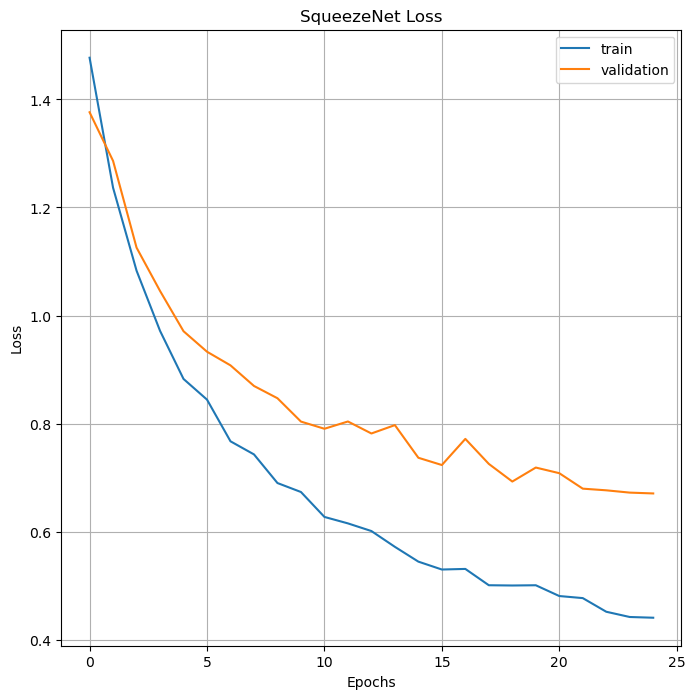

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(squeezenet_history[:, 0:2])
plt.title('SqueezeNet Loss')
plt.legend(['train', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.ylim()
#plt.savefig(dataset+'_loss_curve.png')
plt.show()

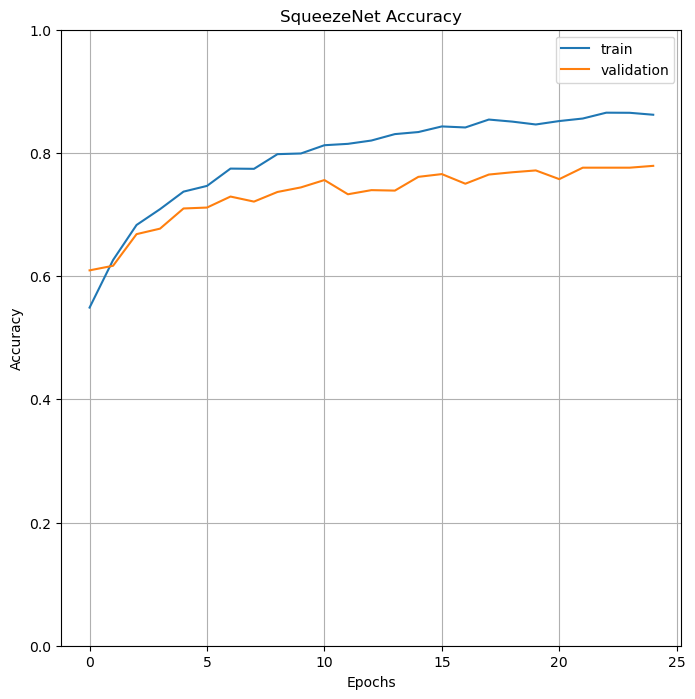

In [27]:
plt.figure(figsize=(8, 8))
plt.plot(squeezenet_history[:, 2:4])
plt.title('SqueezeNet Accuracy')
plt.legend(['train', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid()
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [30]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = squeezenet_transform
    #transform = squeezenet_transform['test']


    test_image = PIL.Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

Predcition 1 : bombus barbutellus , Score:  0.5686383
Predcition 2 : bombus hortorum , Score:  0.3107068
Predcition 3 : bombus lucorum , Score:  0.056563508


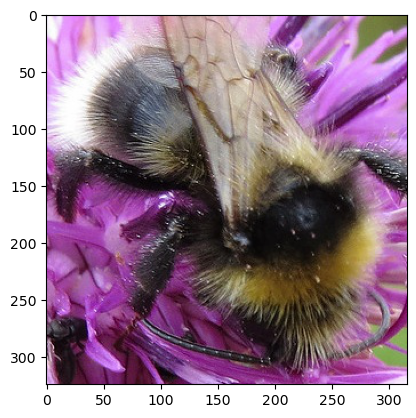

In [31]:
predict(squeezenet, '/home/hduser/Desktop/augmented data pytorch/barbutellus/bombus barbutellus male 21.jpg')